### Import

In [1]:
import uuid
from typing import List, Dict, Any
import os
import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold
from dotenv import load_dotenv
from typing import Callable

# Load environment variables from .env file
load_dotenv()

# Configure Gemini API
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

# Global generation config
GENERATION_CONFIG = {
    "temperature": 1,
    "top_k": 64,
    "max_output_tokens": 1000,
    "response_mime_type": "text/plain",
}

class Agent:
    def __init__(self, name: str, system_instruction: str):
        self.id = str(uuid.uuid4())
        self.name = name
        self.system_instruction = system_instruction
        self.memory: List[Dict[str, Any]] = [] # Memory should be overridden in the subclass

    # TO BE OVERRIDDEN
    def process_message(self, message: Dict[str, Any]) -> Dict[str, Any]:
        raise NotImplementedError("process_message method must be implemented in the subclass")


    def send_message(self, recipient: 'Agent', content: str):
        return recipient.process_message(content)

class GeminiAgent(Agent):
    def __init__(self, name: str, system_instruction: str, end_condition = False, tools = []):
        super().__init__(name, system_instruction)
        self.model = self.create_gemini_model(tools=tools, system_instruction=system_instruction)
        self.chat_session = self.model.start_chat(enable_automatic_function_calling=True)
        self.memory = self.chat_session.history
        self.end_condition = end_condition

    def create_gemini_model(self, tools, system_instruction: str = ""):
        return genai.GenerativeModel(
            model_name="gemini-1.5-pro",
            generation_config=GENERATION_CONFIG,
            safety_settings={
                HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
                HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
                HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
                HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
            },
            system_instruction=system_instruction,
            tools=tools,
        )
    
    def process_message(self, message: Dict[str, Any]) -> Dict[str, Any]:
        # Append user message to history
        self.chat_session.history.append({
            "role": "user",
            "parts": [message],
        })
        
        response = self.chat_session.send_message(message)
        
        # Append model response to history
        self.chat_session.history.append({
            "role": "model",
            "parts": [response.text],
        })
        
        return response.text

class UserAgent(Agent):
    def __init__(self, name: str, system_instruction: str):
        super().__init__(name, system_instruction)
        self.memory = []

    def process_message(self, message: Dict[str, Any]) -> Dict[str, Any]:
        # Append user message to history
        print("Do nothing for now")
    
    def send_message(self, recipient: 'Agent', content: str):
        input_content = input(content)
        print("[user]",input_content)
        message = input_content
        # Append user message to memory
        self.memory.append({
            "role": "user",
            "parts": [input_content],
        })
        return recipient.process_message(message)

class Mediator:
    def __init__(self):
        self.agents: Dict[str, Agent] = {}
        self.agents["user"] = UserAgent("User", "") # Add an user agent as a default agent

    def add_agent(self, agent: Agent):
        self.agents[agent.id] = agent

    def get_agent(self, agent_id: str) -> Agent:
        return self.agents.get(agent_id)

    def send(self, sender_id: str, recipient_id: str, content: str):
        sender = self.get_agent(sender_id)
        recipient = self.get_agent(recipient_id)
        if sender and recipient:
            return sender.send_message(recipient, content)
        else:
            raise ValueError("Invalid sender or recipient ID")
    
    def chat(self, sender_id: str, recipient_id: str, content: str, str_condition: str = "", max_turns: int = 4):
        sender = self.get_agent(sender_id)
        recipient = self.get_agent(recipient_id)
        res_recipient = content
        res_sender = " "
        counter = 0
        end = False
    
        # Repeat for max_turns or until recipient.end_condition is true
        while counter < max_turns and not end:
            res_recipient = self.send(sender_id, recipient_id, res_recipient if counter == 0 else res_sender)
            print(f'[{recipient.name}]', res_recipient)
            if str_condition and str_condition in res_recipient:
                break
            
            if callable(recipient.end_condition):
                # Check if receiver has a function as end_condition
                end = recipient.end_condition()
            
            if end:
                break
                
            res_sender = self.send(recipient_id, sender_id, res_recipient)
            print(f'[{sender.name}]', res_sender)
            if str_condition and str_condition in res_sender:
                break

            # Check if receiver has a function as end_condition
            if callable(sender.end_condition):
                end = sender.end_condition()
                
            counter += 1
        
        return res_sender
    
    def user_chat(self, sender_id: str, recipient_id: str, hint: str="Write your message", str_condition: str = "",  max_turns: int = 4):
        sender = self.get_agent(sender_id)
        res_sender = self.send("user", sender_id, hint)
        print(f'[{sender.name}]', res_sender)
        res = self.chat(sender_id, recipient_id, content=res_sender, str_condition=str_condition, max_turns=4)
        return res
    
    def conductor_chat(self, sender_id: str, recipient_id: str, conductor_id: str, content: str, hint: str="Write your message", max_turns: int = 4, independent: bool = False):
        # Validate agents
        sender = self.get_agent(sender_id)
        recipient = self.get_agent(recipient_id)
        conductor = self.get_agent(conductor_id)
        if not sender or not recipient or not conductor:
            raise ValueError("Invalid sender, recipient, or conductor ID")
        counter = 0
        
        res_sender = self.send(conductor_id, sender_id, content=content) # coductor_id is irrelevant
        print(f'[{sender.name}]', res_sender)
        res = res_sender

        while counter < max_turns:
            # Chat operations
            res_filtered_sender = self.chat(sender_id, conductor_id, res, max_turns=max_turns)
            res_filtered_recipient = self.chat(conductor_id, recipient_id, res_filtered_sender, max_turns=max_turns)
            
            # Update response based on the independent flag
            res = " " if independent else res_filtered_recipient

            counter += 1
            print(f"turn {counter}")

### Chessboard test

In [2]:
import chess
import chess.svg
from typing_extensions import Annotated

board = chess.Board() # Initialize the board

made_move = False # Flag to check if the move has been made

In [3]:
# 1. Tool for getting legal moves
def get_legal_moves(a: str):
    """Get the legal moves for the current board state.
    Args:
        a (str): it does nothing.
    Returns:
        str: A string containing the legal moves.
    """
    return "Possible moves are: " + ",".join(
        [str(move) for move in board.legal_moves]
    )

# 2. Tool for making a move on the board
def make_move(move: str):
    """Make a move on the board.
    Args:
        move (str): The move to make in UCI format.
    Returns:
        str: A string indicating the move made.
    """
    print("Move:", move)
    move = chess.Move.from_uci(move)
    board.push_uci(str(move))
    global made_move
    made_move = True

    # Display the board.
    display(
        chess.svg.board(
            board,
            arrows=[(move.from_square, move.to_square)],
            fill={move.from_square: "gray"},
            size=200
        )
    )

    # Get the piece name.
    piece = board.piece_at(move.to_square)
    piece_symbol = piece.unicode_symbol()
    piece_name = (
        chess.piece_name(piece.piece_type).capitalize()
        if piece_symbol.isupper()
        else chess.piece_name(piece.piece_type)
    )
    return f"Moved {piece_name} ({piece_symbol}) from "\
        f"{chess.SQUARE_NAMES[move.from_square]} to "\
        f"{chess.SQUARE_NAMES[move.to_square]}."

# 3. Tool for checking if the move is valid
def is_valid_move(move: str):
    """Check if the move is valid.
    Args:
        move (str): The move to check in UCI format.
    Returns:
        bool: A boolean indicating if the move is valid.
    """
    print("Move check:", move)
    return chess.Move.from_uci(move) in board.legal_moves

# 4. Tool for resetting the board
def check_made_move():
    global made_move
    if made_move:
        made_move = False
        return True
    else:
        return False

In [4]:
# print(get_legal_moves(" "))
# print(make_move("g1h3"))
# print(get_legal_moves(" "))

### Create Agents

In [5]:
# Player white agent
player_white = GeminiAgent(
    name="Player White",
    system_instruction="You are a chess player and you play as white. "
    "First call get_legal_moves(), to get a list of legal moves. "
     "Then pick a move from the list of legal moves and answer with the move in UCI format.",
    # "Then call make_move(move) to make a move.",
    tools=[get_legal_moves]
)

# Player black agent
player_black = GeminiAgent(
    name="Player Black",
    system_instruction="You are a chess player and you play as black. "
    "First call get_legal_moves(), to get a list of legal moves."
    "Then pick a move from the list of legal moves and answer with the move in UCI format.",
    # "Then call make_move(move) to make a move.",
    tools=[get_legal_moves]
)

# Create a conductor
conductor = GeminiAgent(
    name="Board Conductor",
    system_instruction="You are a chess board conductor. Your job is to collect moves from the players and update the board."
    "Call is_valid_move(move) where move is the move given by the player. If the move is valid, use make_move(move) to update the board. "
    "If the move is invalid, ask the player to make a valid move.",
    end_condition=check_made_move,
    tools=[is_valid_move, make_move]
)


[Player White] e2e4 

Move check: e2e4
Move: e2e4


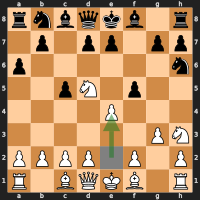

[Board Conductor] Pawn moved from e2 to e4. 







[Player Black] e7e5 



Move check: e7e5
Move: e7e5


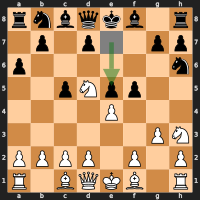

[Board Conductor] Pawn moved from e7 to e5. 

turn 1
[Board Conductor] Waiting for your move. 





[Player White] d2d4 



Move check: d2d4
Move: d2d4


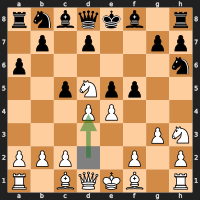

[Board Conductor] Pawn moved from d2 to d4. 







[Player Black] e5d4 



Move check: e5d4
Move: e5d4


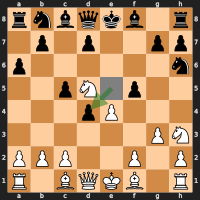

KeyboardInterrupt: 

In [7]:
mediator = Mediator()

mediator.add_agent(player_white)
mediator.add_agent(player_black)
mediator.add_agent(conductor)

#res1 = mediator.chat(conductor.id, player_white.id, content="Start", max_turns=8)

#res2 = mediator.chat(player_white.id, player_black.id, content={"content": " "}, max_turns=8)
#print(res2)

res = mediator.conductor_chat(player_white.id, player_black.id, conductor.id, content=" ", max_turns=8, independent=True)

#mediator.user_chat("user", player_black.id, hint="Start", max_turns=8)

